# Inner-product speed test

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

import bilby
from bilby.gw.utils import calculate_time_to_merger, noise_weighted_inner_product
# dont print bilby output
bilby.core.utils.logger.setLevel("ERROR")

from gwsnr.utils import get_gw_parameters

## SNR with `bilby`

* This traditional method will be compared with `gwsnr` inner-product SNR.

In [13]:
# Waveform arguments for waveform generation
output_jsonfile = 'inner_product_bilby.json'
waveform_approximant = 'IMRphenomD'
minimum_frequency = 20.0
sampling_frequency = 2048.0

waveform_arguments = dict(
    waveform_approximant=waveform_approximant,
    reference_frequency=20.0,
    minimum_frequency=minimum_frequency,
)

# psd objects
psds = dict()
psds["L1"] = "aLIGO_O4_high_asd.txt"
psds["H1"] = "aLIGO_O4_high_asd.txt"
psds["V1"] = "AdV_asd.txt"
list_of_detectors = ['L1', 'H1', 'V1']
ifos = bilby.gw.detector.InterferometerList(list_of_detectors)
psds_objects = []
for i, det in enumerate(list_of_detectors):
    psds_objects.append(
            bilby.gw.detector.PowerSpectralDensity(asd_file=psds[det])
        )

def bilby_inner_product(mass_1=10,
        mass_2=10,
        luminosity_distance=100.0,
        theta_jn=0.0,
        psi=0.0,
        phase=0.0,
        geocent_time=1246527224.169434,
        ra=0.0,
        dec=0.0,
        a_1=0.0,
        a_2=0.0,
        tilt_1=0.0,
        tilt_2=0.0,
        phi_12=0.0,
        phi_jl=0.0,
        lambda_1=0.0,
        lambda_2=0.0,
        eccentricity=0.0,
        gw_param_dict=False,
        mtot_min=9.96, 
        mtot_max=235.0,
        mtot_cut=True,
        fixed_duration=None,
        duration_min=None,
        duration_max=None,
    ):

    # if gw_param_dict is given, then use that
    if gw_param_dict is not False:
        mass_1, mass_2, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, lambda_1, lambda_2, eccentricity  = get_gw_parameters(gw_param_dict)
    else:
        mass_1, mass_2, luminosity_distance, theta_jn, psi, phase, geocent_time, ra, dec, a_1, a_2, tilt_1, tilt_2, phi_12, phi_jl, lambda_1, lambda_2, eccentricity = get_gw_parameters(dict(mass_1=mass_1, mass_2=mass_2, luminosity_distance=luminosity_distance, theta_jn=theta_jn, psi=psi, phase=phase, geocent_time=geocent_time, ra=ra, dec=dec, a_1=a_1, a_2=a_2, tilt_1=tilt_1, tilt_2=tilt_2, phi_12=phi_12, phi_jl=phi_jl, lambda_1=lambda_1, lambda_2=lambda_2, eccentricity=eccentricity))

    if mtot_cut:
        mtot = mass_1 + mass_2
        n = np.where((mtot >= mtot_min) & (mtot <= mtot_max))[0]
    else:
        n = np.arange(len(mass_1))

    opt_snr_all = np.zeros((len(list_of_detectors), len(mass_1)))
    opt_snr_effective = np.zeros(len(mass_1))

    for idx in n:

        # IMPORTANT: time duration calculation for each of the mass combination
        if fixed_duration:
            duration = fixed_duration
        else:
            safety = 1.1
            approx_duration = safety * calculate_time_to_merger(mass_1[idx], mass_2[idx], minimum_frequency)
            duration = np.ceil(approx_duration + 2.0)

            if duration_max and (duration > duration_max):
                duration = duration_max  # IMRPheonomXPHM has maximum duration of 371s
            if duration_min and (duration < duration_min):
                duration = duration_min

        waveform_generator = bilby.gw.WaveformGenerator(
            duration=duration,
            sampling_frequency=sampling_frequency,
            frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole,
            waveform_arguments=waveform_arguments,
        )

        injection_parameters = dict(
            mass_1=mass_1[idx],
            mass_2=mass_2[idx],
            luminosity_distance=luminosity_distance[idx],
            geocent_time=geocent_time[idx],
            theta_jn=theta_jn[idx],
            ra=ra[idx],
            dec=dec[idx],
            psi=psi[idx],
            phase=phase[idx],
            a_1=a_1[idx],
            a_2=a_2[idx],
            tilt_1=tilt_1[idx],
            tilt_2=tilt_2[idx],
            phi_12=phi_12[idx],
            phi_jl=phi_jl[idx],
        )

        polas = waveform_generator.frequency_domain_strain(parameters=injection_parameters)

        opt_snr_dets = []
        snr_effective = 0.
        for j, det in enumerate(list_of_detectors):

            # need to compute the inner product for
            p_array = psds_objects[j].get_power_spectral_density_array(waveform_generator.frequency_array)

            idx2 = (p_array != 0.0) & (p_array != np.inf)
            hp_inner_hp = noise_weighted_inner_product(
                polas["plus"][idx2],
                polas["plus"][idx2],
                p_array[idx2],
                waveform_generator.duration,
            )
            hc_inner_hc = noise_weighted_inner_product(
                polas["cross"][idx2],
                polas["cross"][idx2],
                p_array[idx2],
                waveform_generator.duration,
            )

            Fp = ifos[j].antenna_response(
                ra=ra[idx],
                dec=dec[idx],
                time=geocent_time[idx],
                psi=psi[idx],
                mode='plus'
            )
            Fc = ifos[j].antenna_response(
                ra=ra[idx],
                dec=dec[idx],
                time=geocent_time[idx],
                psi=psi[idx],
                mode='cross'
            )

            snrs_sq = abs((Fp**2) * hp_inner_hp + (Fc**2) * hc_inner_hc)
            snr_effective += snrs_sq

            opt_snr_dets.append(np.sqrt(snrs_sq))

        opt_snr_all[:,idx] = opt_snr_dets
        opt_snr_effective[idx] = np.sqrt(snr_effective)

    # organizing the snr dictionary
    optimal_snr = dict()
    for j, det in enumerate(list_of_detectors):
        optimal_snr[det] = opt_snr_all[j]

    optimal_snr["optimal_snr_net"] = opt_snr_effective
    return optimal_snr

In [2]:
from ler.utils import load_json

param_dict = load_json('param_dict_bbh.json')
# convert to np.array
param_dict_1e5 = {key: np.array(value) for key, value in param_dict.items()}

In [19]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(0)
nsamples = np.array([1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 1e5])
def run_time_cal_bilby(nsamples):
    
    time_list = []
    for n in nsamples:
        # select n samples for each values in the dict
        idx = np.random.choice(len(param_dict_1e5['mass_1']), size=int(n), replace=False)
        param_dict = {key: value[idx] for key, value in param_dict_1e5.items()}

        # measure the time taken for SNR calculation
        start_time = datetime.now()
        snr = bilby_inner_product(gw_param_dict=param_dict)
        end_time = datetime.now()
        execution_time = (end_time - start_time).total_seconds() * 1000  # convert to milliseconds

        time_list.append(execution_time)  # average time over 10 runs

    return nsamples, np.array(time_list)

In [8]:
# _, run_time_bilby_inner_product = run_time_cal_bilby(nsamples)
# # save
# np.save('run_time_bilby_inner_product.npy', run_time_bilby_inner_product)
# load
run_time_bilby_inner_product = np.load('run_time_bilby_inner_product.npy')

In [4]:
run_time_bilby_inner_product

array([ 7675.132, 15763.178, 21293.586, 31483.498, 39764.478,
       45889.148, 50434.777, 60968.971, 66952.214, 74634.555])

## SNR with `gwsnr`

* `gwsnr` inner-product SNR computation is significantly faster than the traditional `bilby` method due to two key optimizations:

    * **JIT compilation**: Utilizes `numba.njit` for just-in-time compilation of computationally intensive functions, including antenna response calculations and power spectral density interpolation.

    * **Parallel processing**: Leverages multi-processing to distribute SNR calculations across multiple CPU cores, enabling parallel computation of large parameter sets.

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from gwsnr import GWSNR

gwsnr = GWSNR(npool=4, snr_type='inner_product', gwsnr_verbose=False, multiprocessing_verbose=False, mtot_cut=True)


Initializing GWSNR class...

psds not given. Choosing bilby's default psds




In [24]:
# gerneral case, random parameters
# add random seed for reproducibility
np.random.seed(0)
nsamples = np.array([1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 1e5])
def run_time_cal_gwsnr(nsamples):
    
    time_list = []
    for n in nsamples:
        # select n samples for each values in the dict
        idx = np.random.choice(len(param_dict_1e5['mass_1']), size=int(n), replace=False)
        param_dict = {key: value[idx] for key, value in param_dict_1e5.items()}
        
        # measure the time taken for SNR calculation
        start_time = datetime.now()
        snr = gwsnr.compute_bilby_snr(gw_param_dict=param_dict)
        end_time = datetime.now()
        execution_time = (end_time - start_time).total_seconds() * 1000  # convert to milliseconds

        time_list.append(execution_time)  # average time over 10 runs

    return nsamples, np.array(time_list)

In [9]:
# _, run_time_gwsnr_inner_product_4cpu = run_time_cal_gwsnr(nsamples)
# # save
# np.save('run_time_gwsnr_inner_product_4cpu.npy', run_time_gwsnr_inner_product_4cpu)
# load
run_time_gwsnr_inner_product_4cpu = np.load('run_time_gwsnr_inner_product_4cpu.npy')

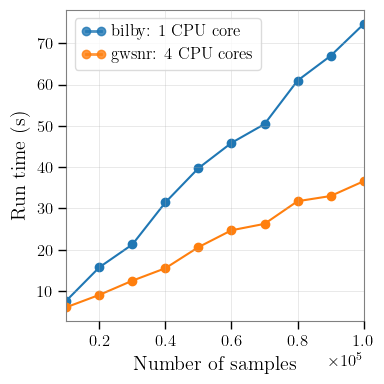

In [11]:
# plotting the run time
plt.figure(figsize=(4, 4))
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
})
nsamples = np.array([1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 1e5])
plt.plot(nsamples, run_time_bilby_inner_product/1000, marker='o', linestyle='-', color='C0', label='bilby: 1 CPU core')
# plt.plot(nsamples, run_time_gwsnr_inner_product/1000, marker='o', linestyle='-', color='C1', label='gwsnr: 8 CPU cores')
plt.plot(nsamples, run_time_gwsnr_inner_product_4cpu/1000, marker='o', linestyle='-', color='C1', label='gwsnr: 4 CPU cores')
plt.xlabel('Number of samples')
plt.ylabel('Run time (s)')
plt.xlim(10000, 100000)
# plt.xscale('log')
# plt.yscale('log')
# legend
legend = plt.legend(handlelength=1.5, loc='upper left', bbox_to_anchor=(0.0, 1.0), frameon=True, fontsize=12, edgecolor='lightgray')
legend.get_frame().set_boxstyle('Round', pad=0.0, rounding_size=0.2)
# Modify line width for legend entries
for handle in legend.get_lines():
    handle.set_linewidth(2)
    handle.set_alpha(0.8)

plt.grid(alpha=0.4)
plt.tight_layout()
plt.savefig('../_static/inner_product_speed_test.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
run_time_bilby_inner_product/run_time_gwsnr_inner_product_4cpu

array([1.25976002, 1.73515721, 1.70034274, 2.02584962,
       1.92645184, 1.85569029, 1.91915557, 1.91947673,
       2.02773713, 2.03936093])

In [10]:
run_time_bilby_inner_product[-1]/

91785.348

In [11]:
# given
nsamples = np.linspace(1000, 1000000, 10)
run_time_jax_gpu = np.array([11.159,  26.794,  34.861,  43.266, 100.089, 108.236, 125.064, 131.672, 139.722, 145.458])
# find run_time_jax_gpu at 1e5
run_time_jax_gpu_1e5 = np.interp(1e5, nsamples, run_time_jax_gpu)

# compare run_time_bilby_inner_product[-1] (1e5) with run_time_jax_gpu_1e5
print("run_time_bilby_inner_product[-1]:", run_time_bilby_inner_product[-1])
print("run_time_jax_gpu_1e5:", run_time_jax_gpu_1e5)
print("speedup:", run_time_bilby_inner_product[-1] / run_time_jax_gpu_1e5)

run_time_bilby_inner_product[-1]: 91785.348
run_time_jax_gpu_1e5: 25.10372972972973
speedup: 3656.2434741042034


In [18]:

nsamples = np.array([1e4, 2e4, 3e4, 4e4, 5e4, 6e4, 7e4, 8e4, 9e4, 1e5])
# run_time_bilby_inner_product
# fit a straight line
from scipy import stats

slope, intercept, r_value, p_value, std_err = stats.linregress(nsamples, run_time_bilby_inner_product)

# extrapolate to 1e6
extrapolated_time = slope * 1e6 + intercept

In [19]:
extrapolated_time

910188.7010909091

In [20]:
extrapolated_time/145.458

6257.398706780714